### **Text Summarization on anonymized data**

In [1]:
!pip install --upgrade --no-cache-dir transformers datasets accelerate

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00


In [3]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d3073c9d58c33f627950cc90cf6400f976cb6a8b74ecf64707c303bbcc8d9e85
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [4]:
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.7 MB/s eta 0:00:00


#### **TRAINING**

In [7]:
# Hugging Face Transformers
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from transformers import LEDTokenizer, LEDForConditionalGeneration


# Loading datasets
dataset = load_dataset("csv", data_files="anonymized_dataset_sample.csv", sep=',', split='train')
print(dataset.column_names)

dataset = dataset.map(lambda x: {"full_note": x["full_note"], "summary": x["anonym_note"]})
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_data = dataset_split["train"]
test_data = dataset_split["test"]

# Tokenization
tokenizer = LEDTokenizer.from_pretrained("allenai/led-base-16384")

def preprocess(example):
    inputs = tokenizer(example["full_note"], truncation=True, padding="max_length", max_length=4096)
    targets = tokenizer(example["summary"], truncation=True, padding="max_length", max_length=512)
    inputs["labels"] = targets["input_ids"]
    return inputs

train_data = train_data.map(preprocess, batched=True)
test_data = test_data.map(preprocess, batched=True)

['index', 'note', 'anonym_note', 'sensitive_entity_note', 'full_note', 'anonym_full_note', 'sensitive_entity_full_note']


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
# Training Arguments
from transformers import LongformerForSequenceClassification
model_clear = LEDForConditionalGeneration.from_pretrained("allenai/led-base-16384")

# Enable gradient checkpointing on the model
model_clear.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir="./results_anonymized_summary",        # folder for checkpoints
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,                # effectively larger batch size
    fp16=True,                                    # mixed precision training
    save_strategy="epoch",                        # save checkpoint at every epoch
    num_train_epochs=2,

    # Logging
    logging_dir="./logs",
    logging_steps=50,                             # more frequent logging
    report_to=["tensorboard","wandb"],            # log to TensorBoard and W&B

    # Learning rate and optimization
    learning_rate=2e-5,                           # more stable LR for small batches
    weight_decay=0.01,                            # regularization
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    lr_scheduler_type="linear",
    warmup_steps=100                              # warmup during first steps
)

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/648M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [9]:
# Trainer
trainer = Trainer(
    model=model_clear,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
)
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: raffaeleaurucci (raffaeleaurucci-universit-degli-studi-di-salerno) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,1.395500
100,0.438800
150,0.273700
200,0.206700
250,0.189900
300,0.168100
350,0.159600
400,0.155300
450,0.155900
500,0.151200


TrainOutput(global_step=500, training_loss=0.3294643249511719, metrics={'train_runtime': 8733.3816, 'train_samples_per_second': 0.916, 'train_steps_per_second': 0.057, 'total_flos': 2.1601638678528e+16, 'train_loss': 0.3294643249511719, 'epoch': 2.0})

In [10]:
!zip -r results_anonymized_summary.zip results_anonymized_summary/checkpoint-500/

  adding: results_anonymized_summary/checkpoint-500/ (stored 0%)
  adding: results_anonymized_summary/checkpoint-500/trainer_state.json (deflated 70%)
  adding: results_anonymized_summary/checkpoint-500/optimizer.pt (deflated 14%)
  adding: results_anonymized_summary/checkpoint-500/config.json (deflated 61%)
  adding: results_anonymized_summary/checkpoint-500/scheduler.pt (deflated 62%)
  adding: results_anonymized_summary/checkpoint-500/generation_config.json (deflated 33%)
  adding: results_anonymized_summary/checkpoint-500/model.safetensors (deflated 11%)
  adding: results_anonymized_summary/checkpoint-500/scaler.pt (deflated 64%)
  adding: results_anonymized_summary/checkpoint-500/rng_state.pth (deflated 26%)
  adding: results_anonymized_summary/checkpoint-500/training_args.bin (deflated 53%)


In [11]:
losses = [x["loss"] for x in trainer.state.log_history if "loss" in x]

for step, loss in enumerate(losses, 1):
    print(f"Step {step} - Training Loss: {loss}")

Step 1 - Training Loss: 1.3955
Step 2 - Training Loss: 0.4388
Step 3 - Training Loss: 0.2737
Step 4 - Training Loss: 0.2067
Step 5 - Training Loss: 0.1899
Step 6 - Training Loss: 0.1681
Step 7 - Training Loss: 0.1596
Step 8 - Training Loss: 0.1553
Step 9 - Training Loss: 0.1559
Step 10 - Training Loss: 0.1512


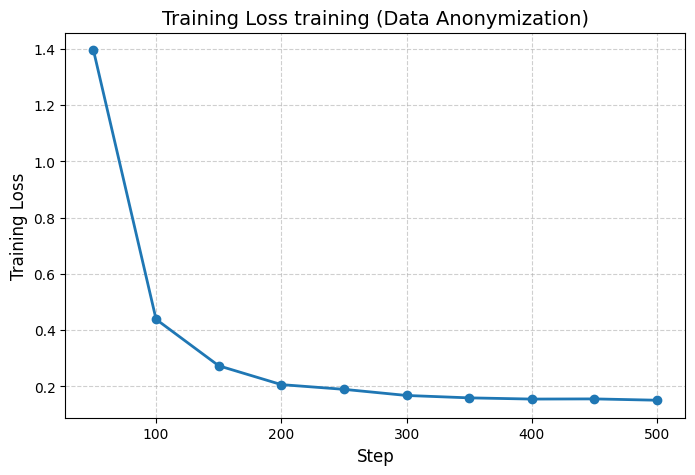

In [4]:
import matplotlib.pyplot as plt

# Data
steps = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
losses = [1.3955, 0.4388, 0.2737, 0.2067, 0.1899, 0.1681, 0.1596, 0.1553, 0.1559, 0.1512]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o', linestyle='-', linewidth=2, markersize=6)

# Label e title
plt.title("Training Loss (Data Anonymization)", fontsize=14)
plt.xlabel("Step", fontsize=12)
plt.ylabel("Training Loss", fontsize=12)

# Grid
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

In [12]:
from transformers import pipeline, logging
from tqdm import tqdm

# Disable warnings
logging.set_verbosity_error()

# Disable gradient checkpointing
model_clear.gradient_checkpointing_disable()

# Summarization pipeline
summarizer_clear = pipeline("summarization", model=model_clear, tokenizer=tokenizer, device=0)

# Test set
test_texts = [ex["full_note"] for ex in test_data]

# List to store the generated summaries
generated_summaries = []

# Progress bar with tqdm
for text in tqdm(test_texts, desc="Generating summary"):
    summary = summarizer_clear(
        text,
        max_length=512,
        min_length=400,
        truncation=True
    )[0]["summary_text"]
    generated_summaries.append(summary)

# Number of inferences
num_inferenze = len(generated_summaries)
print(f"Number of inferences: {num_inferenze}")

# Reference summaries
references = [ex["summary"] for ex in test_data]

Generating summary:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py:1636: UserWarning: Unfeasible length constraints: `min_length` (400) is larger than the maximum possible length (257). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Generating summary: 100%|██████████| 1000/1000 [56:27<00:00,  3.39s/it]


Number of inferences: 1000


In [13]:
generated_summaries[0]

'The patient was a [DATE] [GENDER] who presented with [PROBLEM] of the proximal third of [GENDER] left leg. [GENDER] prior history included a prolonged stay in hospital for [TREATMENT] of [PROBLEM], when [TREATMENT] were performed. [GENDER] had also previously undergone [TREATMENT] to treat [PROBLEM] and [TREATMENT].\r\nPhysical examination revealed [PROBLEM] of the proximal third of the left leg. Femoral, popliteal, and dorsal pedal pulses were palpable and normal in both lower limbs. The posterior tibial artery pulse was absent, whereas the posterior tibial artery pulse was palpable in the right lower limb.\r\nMagnetic resonance angiography showed [PROBLEM] with a [QUANTITY] diameter, at the level of the origin of the posterior tibial artery. The posterior tibial artery was also occluded ( ). Investigation was supplemented with laboratory tests (inflammatory activity tests, coagulation tests, and complete blood cell count), which all returned normal results, in addition to blood cult

In [14]:
# Evaluations
import evaluate

# ROUGE
rouge = evaluate.load("rouge")

results_clear = rouge.compute(predictions=generated_summaries, references=references)
print("ROUGE - Model on anonymized data:")
for k, v in results_clear.items():
    print(f"{k}: {v:.4f}")

ROUGE - Model on anonymized data:
rouge1: 0.6109
rouge2: 0.5771
rougeL: 0.5958
rougeLsum: 0.6045


In [15]:
# BLEU
bleu = evaluate.load("bleu")

references_bleu = [[ref] for ref in references]

results_bleu = bleu.compute(predictions=generated_summaries, references=references_bleu)

print(f"BLEU score: {results_bleu['bleu']:.4f}")

BLEU score: 0.2922


In [16]:
from bert_score import score

# BERTScore
P, R, F1 = score(generated_summaries, references, lang="en", verbose=True)

print(f"Precision: {P.mean().item():.4f}")
print(f"Recall: {R.mean().item():.4f}")
print(f"F1: {F1.mean().item():.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/32 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 107.46 seconds, 9.31 sentences/sec
Precision: 0.9588
Recall: 0.8994
F1: 0.9281


In [ ]:
from statistics import mean

texts = [ex["summary"] for ex in train_data]
token_lengths = [len(tokenizer(text)["input_ids"]) for text in texts]
avg_tokens = mean(token_lengths)

print(f"Average token per entry in train set: {avg_tokens:.2f}")

Average token per entry in train set: 444.89


In [17]:
import csv
from google.colab import files

with open("../datasets/summaries/summaries_anonymized.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["full_note", "summary"])
    for full_note, summary in zip(test_texts, generated_summaries):
        writer.writerow([full_note, summary])

files.download("summaries_anonymized.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>